In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as colors
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# custom libs
from Task_1 import custom_log_reg

# Task 1: build a kernelized logistic regressor

To implement the kernel logistic regression I created a dedicate class which contained 3 modules:

- **fit:** the function first cast the input to a numpy.array (I added this part since it is easier to handle data in a pandas DF format) and then I saved the number of instances (m). Then I computed the kernel matrix with the function that was instantiated when initializing the function using the keywords "gaussian" or "linear" (notice that only a RBF and a Linear Kernel are implemented at the moment! The kernel matrix is then saved inside the class. To add more kernel it is necessary to update the __init__ module of the class and to create the appropriate kernel function. I did not add them since only the RBF kernel was requested, but I implemented a scalable function, like requested in the assignment). Then I initialize a vector of zeros for the alpha weights with the same dimension as the numebr of instances. Subsequently I implemented the vanilla GD (executed for max_iter iterations) computing the gradient of the logistic regression cost function (see the code for the math). Finally I saved the logistic regression cost at the current iteration in a list and I returned it. The tuned weights are saved inside the class and are available for the next parts.

- **predict_prob:** the function computes the sigmoid of the dot product between the trained alphas and the already computed kernel matrix, those are the probabilities.

- **predict:** calls predict_prob to get the probabilities and then applies a threshold to get the labels in the binary classification problem

# Import data

In [2]:
hf = h5py.File("regression.h5", "r")
x_train = np.array(hf.get("x_train"))
y_train_double = np.array(hf.get("y_train"))
x_test = np.array(hf.get("x_test"))
y_test_double = np.array(hf.get("y_test"))
hf.close()

y_train_double = np.stack(y_train_double, axis=1 )
y_test_double = np.stack(y_test_double, axis=1 )



# scale the data
my_scaler = StandardScaler()
x_train = my_scaler.fit_transform(x_train)
x_test = my_scaler.transform(x_test)

# create a pandas df
columns = ["x", "y", "age_house", "carbon_emission", "dist_school", "avg_child_neigh"]
x_train = pd.DataFrame(x_train, columns = columns)
x_test = pd.DataFrame(x_test, columns = columns)
y_train = pd.Series(y_train_double[0], name="Chimney")
y_test = pd.Series(y_test_double[0], name="Chimney")



# Subtask 1: Kernelized Logistic Regression

The cost at the iteration 0 is 690.2992457518601
The cost at the iteration 200 is 676.7011510162456
The cost at the iteration 400 is 674.819113435558
-----------------------------------
The accuracy score on train resulted to be: 0.998
The accuracy score on test resulted to be: 0.531


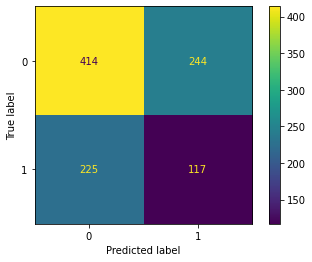

In [3]:
# set my parameters
maxIter = 600
lr = 0.01
sigma = 0.01
alpha = np.zeros(4)

# create the ML dataframes
x_train_1 = x_train.loc[:, ['x', 'y']]
x_test_1 = x_test.loc[:, ['x', 'y']]

my_log_reg = custom_log_reg(kernel='gaussian', hyper_kernel=sigma)
costs = my_log_reg.fit(X=x_train_1, y=y_train, lr=lr, max_steps=maxIter, Lambda = 0.001, verbose = True)

# assess the results!
Z = my_log_reg.predict(x_test_1, threshold=0.5)
Z_train = my_log_reg.predict(x_train_1, threshold=0.5)

print("-----------------------------------")
print("The accuracy score on train resulted to be: {}".format(accuracy_score(Z_train, y_train)))
print("The accuracy score on test resulted to be: {}".format(accuracy_score(Z, y_test)))

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(Z, y_test))
disp.plot()

# subtask 2: get better results!

In this task we use all the training data to do the regression. Since we are using a lot of features we need to have fast kernel computations i.e. not computing puntually each element of the kernel matrix! A nice way to do that is using the fact that you can compute the norm of each element of the design matrix and storing it. This avoid to compute the norm each iteration saving time, in fact that ||x_i-x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2 * x_i^T * x_j.
I also implemented the operations s.t. we are using matrix notation, making it more readable.


The cost at the iteration 0 is 6.965348489095306
The cost at the iteration 200 is 5.360257199672918
The cost at the iteration 400 is 5.196157338750665
-----------------------------------
The accuracy score on train resulted to be: 1.0
The accuracy score on test resulted to be: 0.532


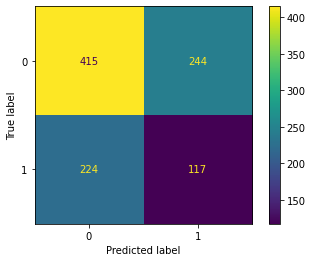

In [4]:
# set my parameters
maxIter = 600
lr = 0.001
sigma = 0.01
var = 100
Lambda = 0.001
alpha = np.zeros(4)

my_log_reg = custom_log_reg(kernel='custom', hyper_kernel=(sigma, var))
costs = my_log_reg.fit(X=x_train, y=y_train, lr=lr, max_steps=maxIter, Lambda = Lambda, verbose = True)

# assess the results!
Z = my_log_reg.predict(x_test, threshold=0.5)
Z_train = my_log_reg.predict(x_train, threshold=0.5)

print("-----------------------------------")
print("The accuracy score on train resulted to be: {}".format(accuracy_score(Z_train, y_train)))
print("The accuracy score on test resulted to be: {}".format(accuracy_score(Z, y_test)))

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(Z, y_test))
disp.plot()

# Try some Grid_search cross validation!

In [5]:
# set my parameters
maxIter = 600
lr = 0.001

grid_sigma = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
grid_var = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
grid_Lambda = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

params = []
accuracies_test = []
accuracies_train = []

num_train = len(grid_sigma) * len(grid_var) * len(grid_Lambda) 
counter = 1

for sigma in grid_sigma:
    for var in grid_var:
        for Lambda in grid_Lambda:
            my_log_reg = custom_log_reg(kernel='custom', hyper_kernel=(sigma, var))
            costs = my_log_reg.fit(X=x_train, y=y_train, lr=lr, max_steps=maxIter, Lambda = Lambda)
            
            # assess the results!
            Z = my_log_reg.predict(x_test, threshold=0.5)
            Z_train = my_log_reg.predict(x_train, threshold=0.5)
            
            # saving accuracies and settings
            accuracies_test.append(accuracy_score(y_test, Z))
            accuracies_train.append(accuracy_score(y_train, Z_train))
            params.append({
                "sigma" : sigma,
                "var" : var,
                "Lambda" : Lambda
            })
            
            # progresses
            print("Traings done : {} / {}".format(counter, num_train), end="\r")
            counter += 1


In [6]:
print(accuracies_test)

[0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361